<h1>Sparse coding with an overcomplete basis set.</h1>
The authors begin with the assumptions of the efficient coding hypothesis, which is roughly that neurons have evolved to represent the enviroment with as few spikes as possible. Thus with respect to ethologically relevant stimuli, neurons will reduce statistical with respect to their own and other neurons spikes. For example two neurons with the same receptive field would not have the same stimuli selectivity or else they would be perfectly dependent.
They go further in stating that one interpretation is that neurons would be pushed to represent independent events in the enviroment, thus giving rise to our perceptual representation of inndependent entities that give rise to an image (objects).
They will interpret this goal into probabilistically defined objective for which a mostly linear model of a neural population will be tuned.

<h2>Image coding model</h2>
<h3>Analysis</h3>
A common code for an image $I$ is the set of coefficients $b$ resulting from the product of a set of basis functions $\psi_i$ with the image $I$

$$b_i = \sum_{\vec{x}_j} \psi_i(\vec{x}_j)I(\vec{x}_j) $$


Another way of writing this in matrix notation is:
$$b=WI$$
* $W_{i,j} = \psi_i(\vec{x}_j) $ and is $n \times p$ with $n$ pixels, and $p$ basis functions.
* $I_j = I(\vec{x}_j)$ is our image unwrapped into a vector with $n$ pixels indexed by $j$

<h3>Synthesis</h3>
A different perspective for the code of an image is the linear superposition of a set of basis functions. 

$$I(\vec{x}) = \sum_{i} a_i \phi(\vec{x})$$

* $I(\vec{x})$ is again the values of our image.
* But constructed from a linear combination of basis functions $\phi(\vec{x})$

In some cases $ \phi(\vec{x}) = \psi(\vec{x})$, if they are an orthonormal basis. In this paper this will not be the case. They instead work with an overcomplete basis, where the number of basis functions exceeds the dimensionality of input, so that there is no unique set of coefficients $a_i$ to describe the image.

One reason for this choice is that it might be more robust to noise, i.e. with more basis functions one is more likely to achieve high covariance with a given signal ...

They also argue that images might have more independent causes then the dimensionality of the input. 

<h2>Probabilistic Framework </h2>

The authors ask what $\phi$ can account for the structure of natural image in terms of sparse independent events. 
Thus they want to make a distribution $P(I|\phi)$ that best matches $P^*(I)$ the distribution of natural images. They specify this distribution as:
$$P(I|\phi) = \int{P(I|a, \phi)P(a) da}$$
The probability of an image in this model is the product of the distribution of coefficients, and the probability of an image given a set of coefficients.

<h3>$P(I|a, \phi)$</h3>
The imaging model we assume is:
$$I(\vec{x}) = \sum_i a_i \phi_i(\vec{x}) + v(\vec{x})$$
Images are the sum of basis functions, and white gaussian noise.
Thus the probability of an image arising from a set of coefficients $a$ is:

$$\large P(I|a, \phi) = \frac{1}{Z_{\sigma N}}e^{\frac{|I-a\phi|^2}{2\sigma^2}}$$

* $Z$ normalizes the function to a PDF.
* $\sigma$ is our noise variance. 
* $N$ is the dimensionality of our image.

* $|I-a\phi|^2 = \sum_\vec{x} [ I(\vec{x})-\sum_i a_i \phi_i(\vec{x})]^2$ the squared distance between the image, and the image constructed by the coefficients. 

Since we are working with an overcomplete basis there will be infinite $a$ that could reproduce an image.

<h3>$P(a)$</h3>
Here we impose the constraint of sparse independent features. 

* Sparsity: The marginals of $P(a)$ will have high kurtosis by choosing a distribution of the form.
$$P(a_i) = \frac{1}{Z_\beta}e_{-\beta S(a_i)} $$
    * S shapes the distribution.
    * $\beta$ determines steepness
    * $Z_{\beta}$ normalizes to one. 
    * $\beta = 1$ and $S(x)=log(1+x^2)$ corresponds to the Cauch distribution, which has a peak at zero and heavy tails
   


* Independence: The features will have independence imposed upon them by choosing their joint distribution to be the product of their marginals.

$$P(a) = \prod_i P(a_i)$$

<h4>Determining fit of $P(I|\phi)$ to  $P(I)^*$</h4>
To measure the fit between the two distributions they use the Kullback-Leibler divergence:

$$KL = \int P(I)^* \log \frac{P(I)^*}{P(I|\phi)} $$ 

This measure is equal to 0 when the two distributions are the same. It measures the average amount of information per natural image as to whether it came from the distribution of natural images as opposed to the proposed model.
Since $P(I)^*$ is fixed we are just trying to maximize.
$$\log P(I|\phi)$$
 

<h4>Minimizing KL</h4>
The authors recast the problem as one of minimization:

$$E(I,a|\phi) = -\log P(I|\phi)$$

Taking the logarithm of $P(I|\phi) = P(a) P(I|a, \phi)$ both of which were cast as exponetial functions results in a cost function purely in terms of their exponents (presumably they dropped the normalizing constants):

$$E(I,a|\phi) = \sum_{\vec{x}}[I(\vec{x})- \sum_{i} a_i \phi_i(\vec{x})]^2 + \lambda \sum_i S(a_i)$$

We can remember that this second term enforced a prior distribution on a, and the second the likelihood that an image came from a set of $a_i$.

The authors develop their own homebrewed optimization method for a particular S. Dictionary learning has come far enough that there are established methods, and so I will use one from the SKlearn package.

In [95]:
from time import time
import os, sys
import numpy as np
top_dir = os.getcwd().split('v4cnn')[0]
;sys.path.append(top_dir+ 'v4cnn/')
sys.path.append( top_dir + 'xarray');top_dir = top_dir + 'v4cnn/';
sys.path.append( top_dir + 'common/')
sys.path.append(top_dir +'/nets')
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version
from PIL import Image
#image = sp.io.loadmat(top_dir + 'images/DSC_0003_RGB.mat',squeeze_me=True)
#image = image['RGB_Image']
image = sp.misc.imread(top_dir + 'images/IMG_0049.jpg')
image = image[::5, ::5]
image = image.astype(float)
image = image / np.max(image)
image = image - np.min(image)
#image = image - image.mean((0, 1), keepdims=1)
#image = image / np.sum(image**2)**0.5


([], <a list of 0 Text yticklabel objects>)

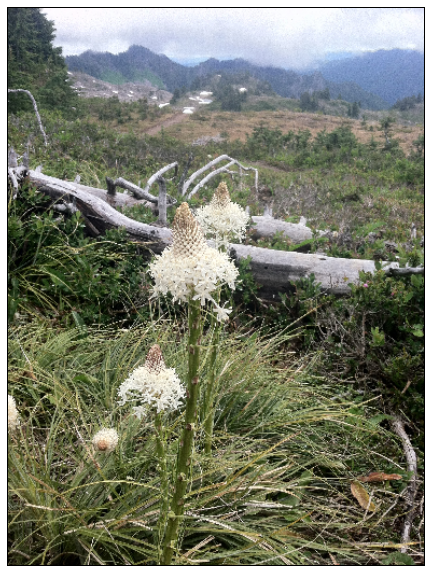

In [96]:
plt.figure(figsize=(10,10))
plt.imshow(image);plt.xticks([]);plt.yticks([])

In [102]:
patch_size = 10
data = extract_patches_2d(image, (patch_size, patch_size))
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
#ft_data = np.fft.nfft(data)


data = data.reshape(data.shape[0], np.product(data.shape[1:]))
print(data.shape)
print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=12, alpha=10, n_iter=1000)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)


(193290, 300)
Learning the dictionary...
done in 6.33s.


(193290, 10, 10, 3)
[[ 0.71068592  0.57840582  0.20016989]
 [ 0.7310212   0.58056265  0.18528011]
 [ 0.79900406  0.65098521  0.22357619]
 [ 0.79120331  0.61769998  0.16293192]
 [ 0.77571358  0.59721807  0.13029728]
 [ 0.79207754  0.59994283  0.10040057]
 [ 0.90212904  0.70342777  0.13656332]
 [ 0.91139632  0.70403241  0.10625694]
 [ 0.90445715  0.68180225  0.05698599]
 [ 0.86832182  0.62191432  0.        ]]


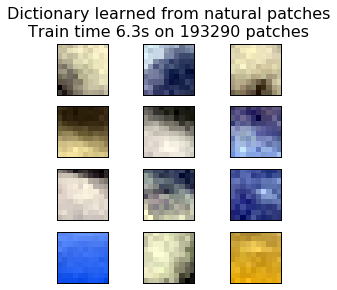

In [103]:
V = V.reshape(np.shape(V)[0], patch_size, patch_size, 3)
data = data.reshape(data.shape[0], patch_size, patch_size, 3)
print(data.shape)
V = V - np.min(V,(1,2,3),keepdims=1)
V = V / V.max((1,2,3), keepdims=True)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V):
    plt.subplot(4, 3, i + 1)
    plt.imshow(comp,interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from natural patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
print(comp[:,0,:])